<a href="https://colab.research.google.com/github/hdn0101/survivalanalysis/blob/main/Survival_Analysis_Tesco_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Survival Analysis - Telco Customer Churn:**

# **I. INTRODUCTION:**

We will be using Telco Customer Churn data from Kaggle
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

**Attribute Information:**

The raw data contains 7043 rows (customers) and 21 columns (features). The “Churn” column is our target.

The data set includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents




# **II. DATA EXPLORATION**

In [ ]:
# install libraries
%pip install lifelines
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

from lifelines.plotting import plot_lifetimes  # Lifelines package for Survival Analysis

# Set up inline plotting (only needed in Jupyter Notebooks)
%matplotlib inline

# Set figure size
plt.rcParams["figure.figsize"] = (12, 6)

**a. Import Data:**

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Survival Analysis/Telco Customer Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


***b. Exploratory Data Analysis ***

In [ ]:
## Data Types and Missing Values in Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


As seen above, we need to convert TotalCharges and Churn to numeric values.

In [ ]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

In [ ]:
## Replace Yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [ ]:
## Review after converting the column TotalCharges to numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Check for missing values
print(df['TotalCharges'].isnull().sum())

11


In [ ]:
# Impute missing values with the median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [ ]:
# Verify if null values are filled
print(df['TotalCharges'].isnull().sum())

0


In [ ]:
# Check CustomerID for duplicate
df["customerID"].duplicated().sum()

0

In [ ]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [ ]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  gender
gender
Male      3555
Female    3488
Name: count, dtype: int64
-----------------------------
Column Name:  Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64
-----------------------------
Column Name:  Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
-----------------------------
Column Name:  PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
-----------------------------
Column Name:  MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
-----------------------------
Column Name:  InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
-----------------------------
Column Name:  OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
-----------------------------
Column Name:  OnlineB

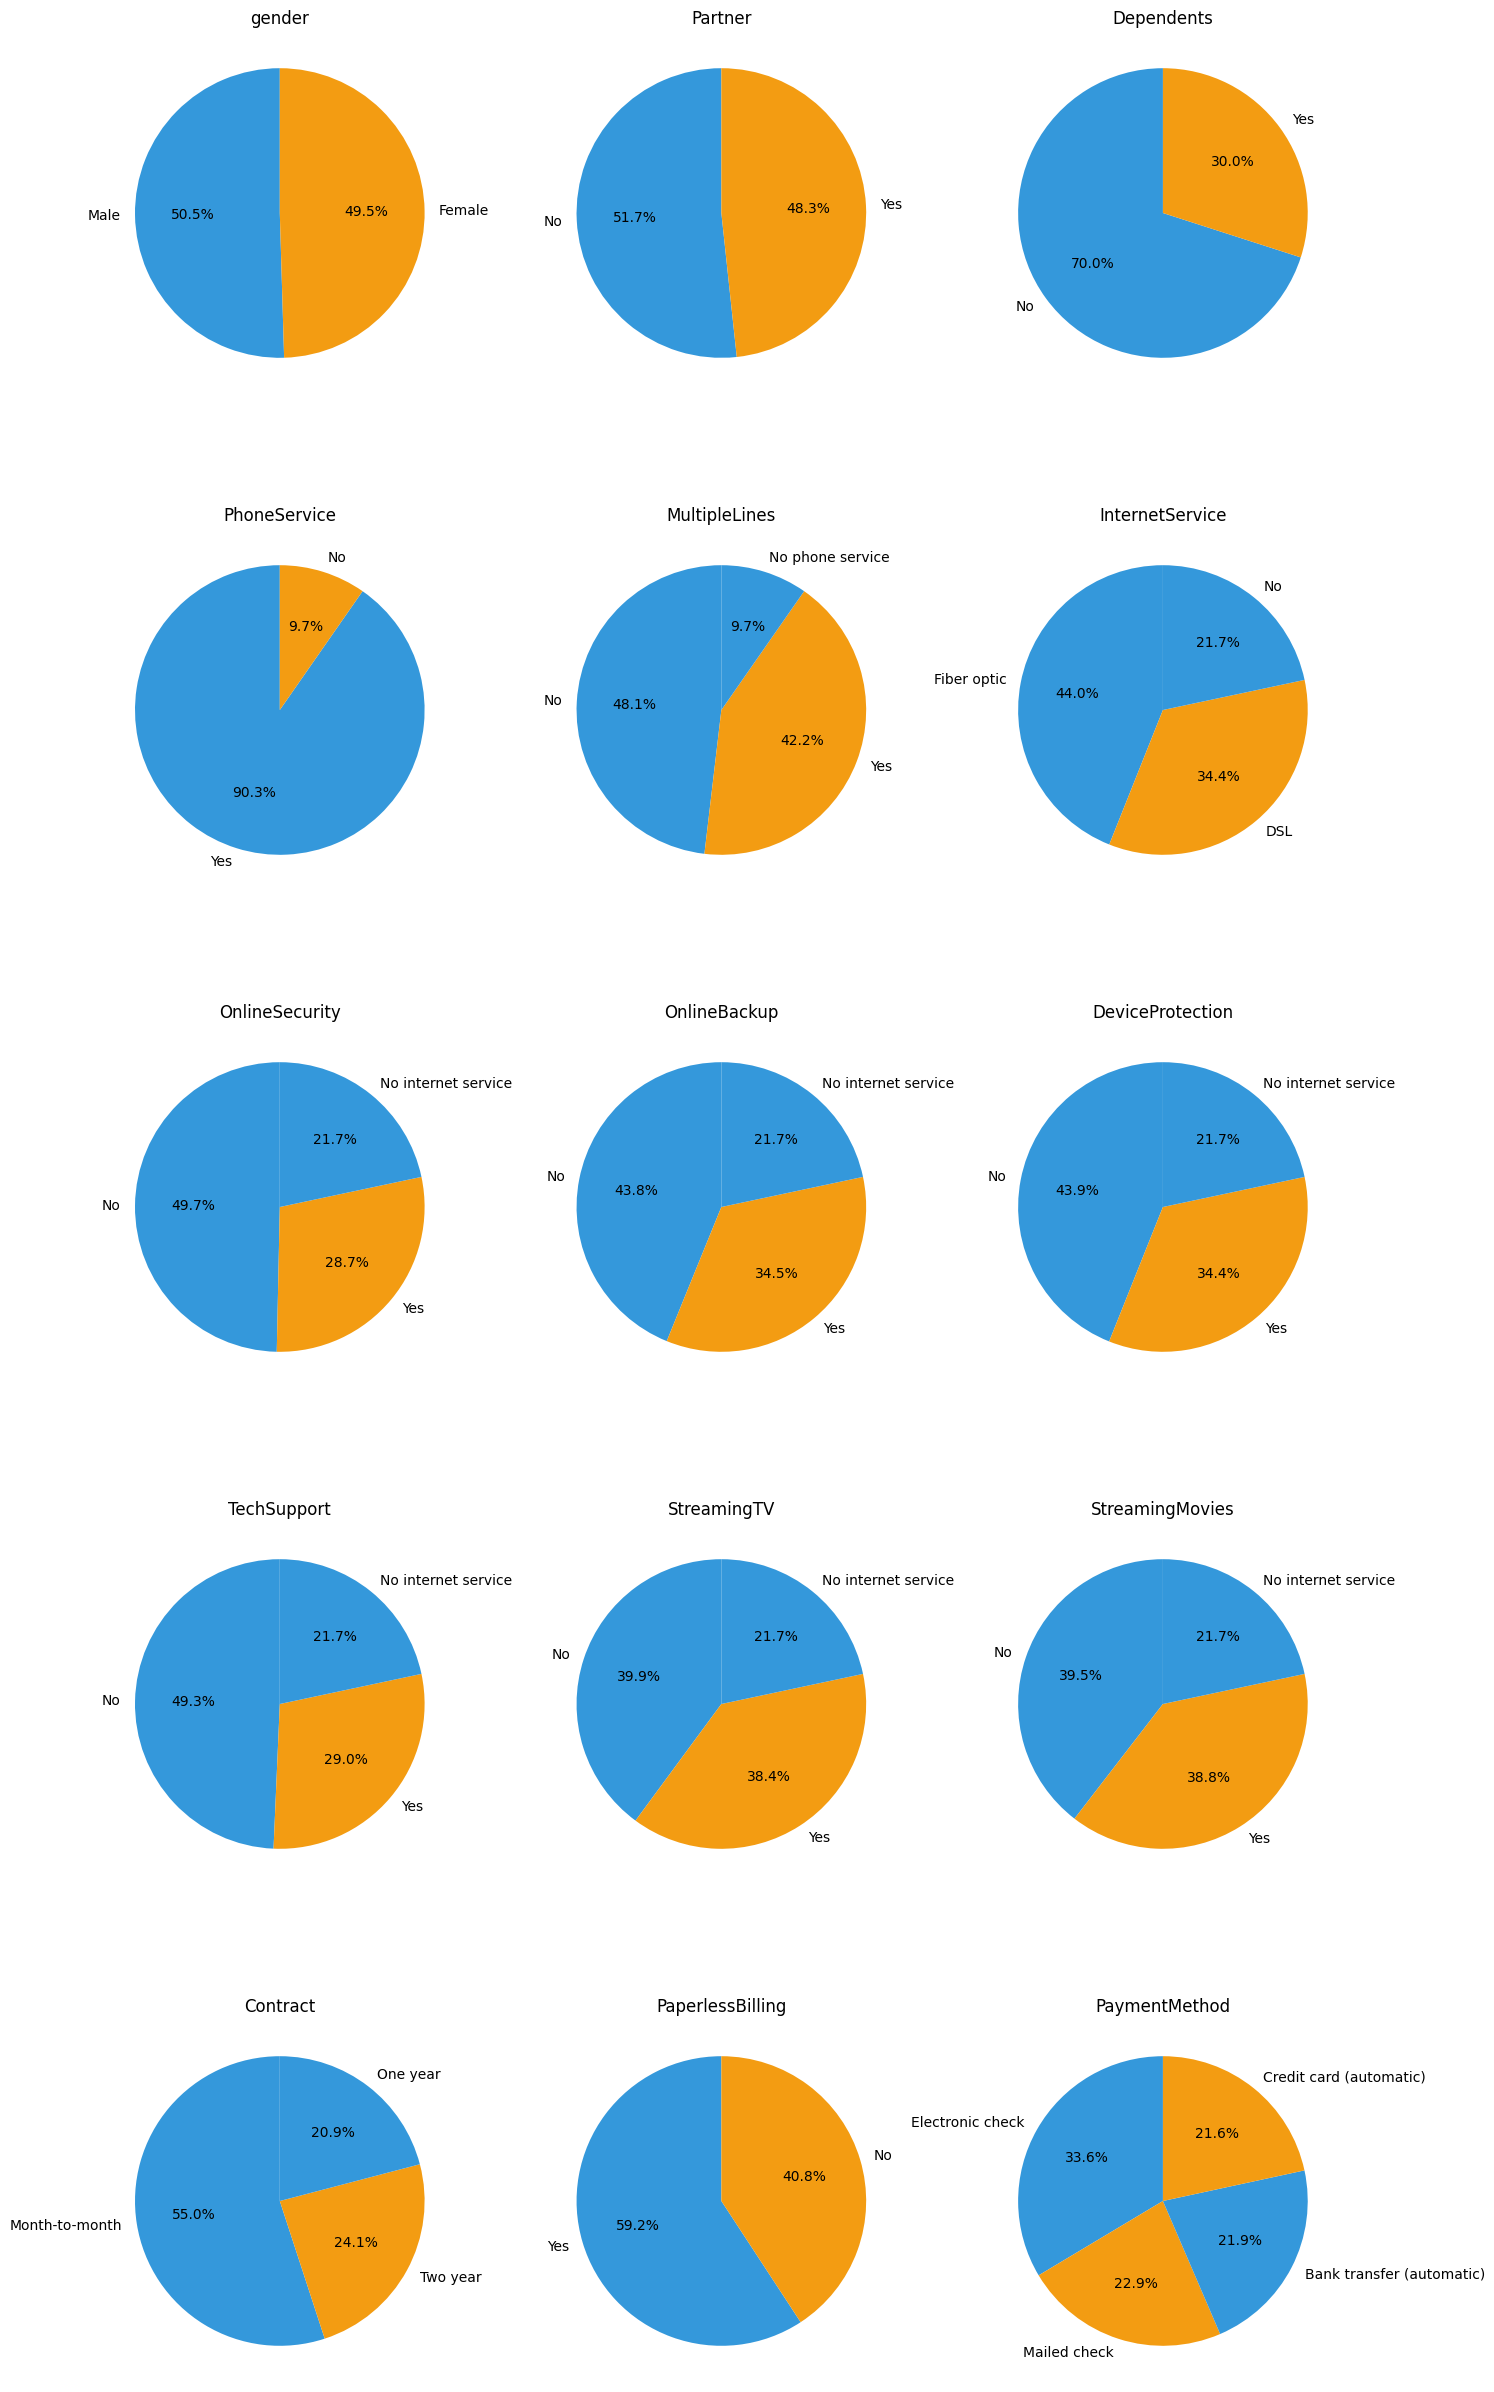

In [ ]:
import matplotlib.pyplot as plt
import math

# Determine the number of rows and columns based on the number of categorical columns
num_cols = len(cat_cols)
num_rows = math.ceil(num_cols / 3)  # Adjust row count dynamically

plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on number of rows

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(num_rows, 3, idx)  # Dynamically adjust the grid size
    df[col].value_counts().plot.pie(autopct='%1.1f%%', colors=['#3498db', '#f39c12'], startangle=90)
    plt.title(col)
    plt.ylabel('')  # Hide y-label for better clarity

plt.tight_layout()
plt.show()

In [ ]:
# Now, let's generate descriptive statistics for the dataframe.
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928,0.265370
std,0.368612,24.559481,30.090047,2265.270398,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,402.225000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [ ]:
# Also the SeniorCitizen Column contains int64 datatype which is nothing but 0(not Senior Citizen) and 1(is Senior Citizen).
# It would be easier to understand if the datatype would be object(Yes/No).
# Let's create a functions which changes the one's and zero's to yes and no.

def conv(value):
    if value == 1:
        return "Yes"
    else:
        return "No"

# Now apply this function in the SeniorCitizen column
df['SeniorCitizen'] = df["SeniorCitizen"].apply(conv)

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Now let's try to figure out why some customers decided to churn out, but before that lets see how many customers have churned out.

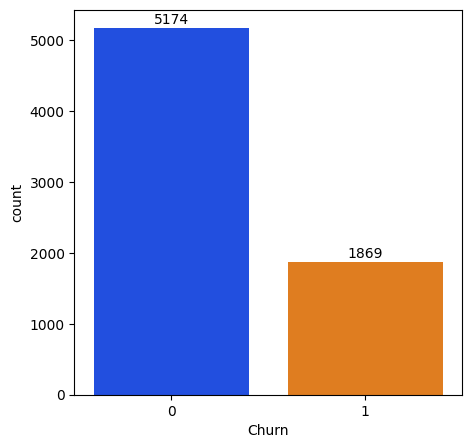

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
abc = sns.countplot(x='Churn', data = df, palette='bright')
for container in abc.containers:
    abc.bar_label(container, fontsize=10, padding=1, color='black')

plt.show()

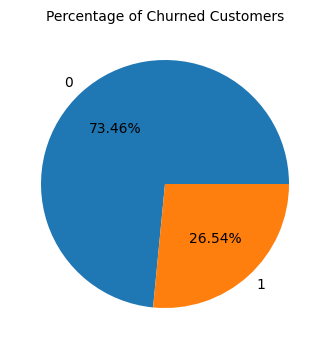

In [ ]:
# Creating pie chart of churned customers
plt.figure(figsize=(4,5))
gb = df.groupby('Churn').agg({'Churn':'count'})
plt.pie(gb['Churn'], labels = gb.index, autopct = "%1.2f%%")
plt.title("Percentage of Churned Customers", fontsize = 10)
plt.show()

Observation

So out of 7043 customers, 1869 customers or 26.54% of customers have churned out.

Now lets see the customers who churned out based on the features like gender, Senior Citizen, etc.

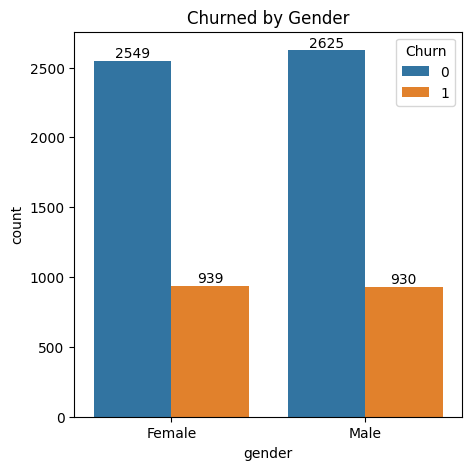

In [ ]:
# Countplot of churned customers based on gender.
plt.figure(figsize = (5,5))
abc = sns.countplot(x = "gender", data = df, hue = 'Churn')
for container in abc.containers:
    abc.bar_label(container, fontsize=10, padding=0, color='black')
plt.title("Churned by Gender")
plt.show()

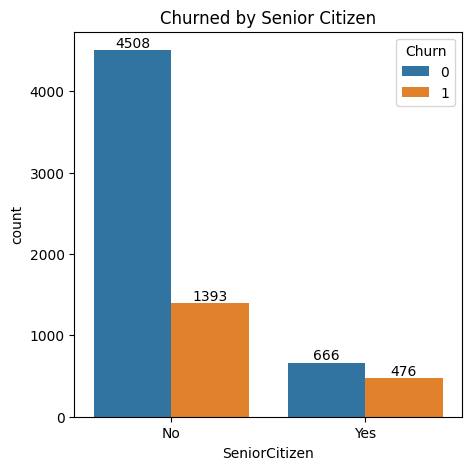

In [ ]:
# Countplot of churned customers based on Senior.
plt.figure(figsize = (5,5))
abc = sns.countplot(x = "SeniorCitizen", data = df, hue = 'Churn')
for container in abc.containers:
    abc.bar_label(container, fontsize=10, padding=0, color='black')
plt.title("Churned by Senior Citizen")
plt.show()

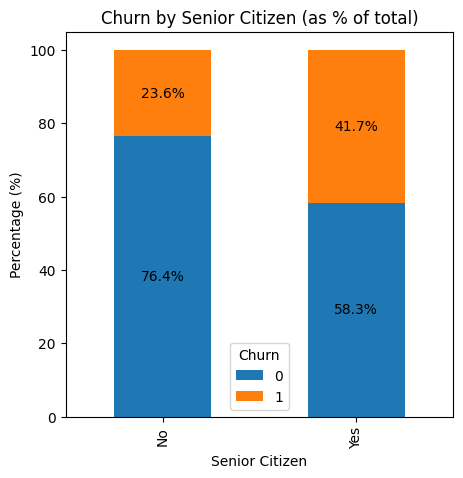

In [ ]:
# Calculate the percentage of Churn within each SeniorCitizen group
pivot_df = df.groupby(['SeniorCitizen', 'Churn']).size().unstack(fill_value = 0)
pivot_df_percent = pivot_df.divide(pivot_df.sum(axis = 1), axis = 0) * 100

# Create the stacked bar chart
ax = pivot_df_percent.plot(kind = 'bar', stacked = True, figsize = (5,5))

# Add labels on the bars to show percentage
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2

    # Annotate with percentage
    ax.annotate(f'{height:.1f}%', (x, y), ha = 'center', va = 'center')

plt.title("Churn by Senior Citizen (as % of total)")
plt.xlabel("Senior Citizen")
plt.ylabel("Percentage (%)")
plt.show()

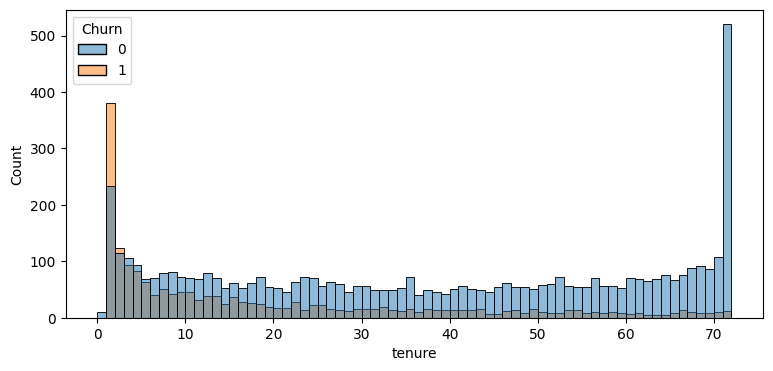

In [ ]:
# Histplot of churned customers based on tenure.
plt.figure(figsize = (9,4))
sns.histplot(x = 'tenure', data = df, bins = 72, hue = 'Churn')
plt.show()

In [ ]:
# Review all the columns
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

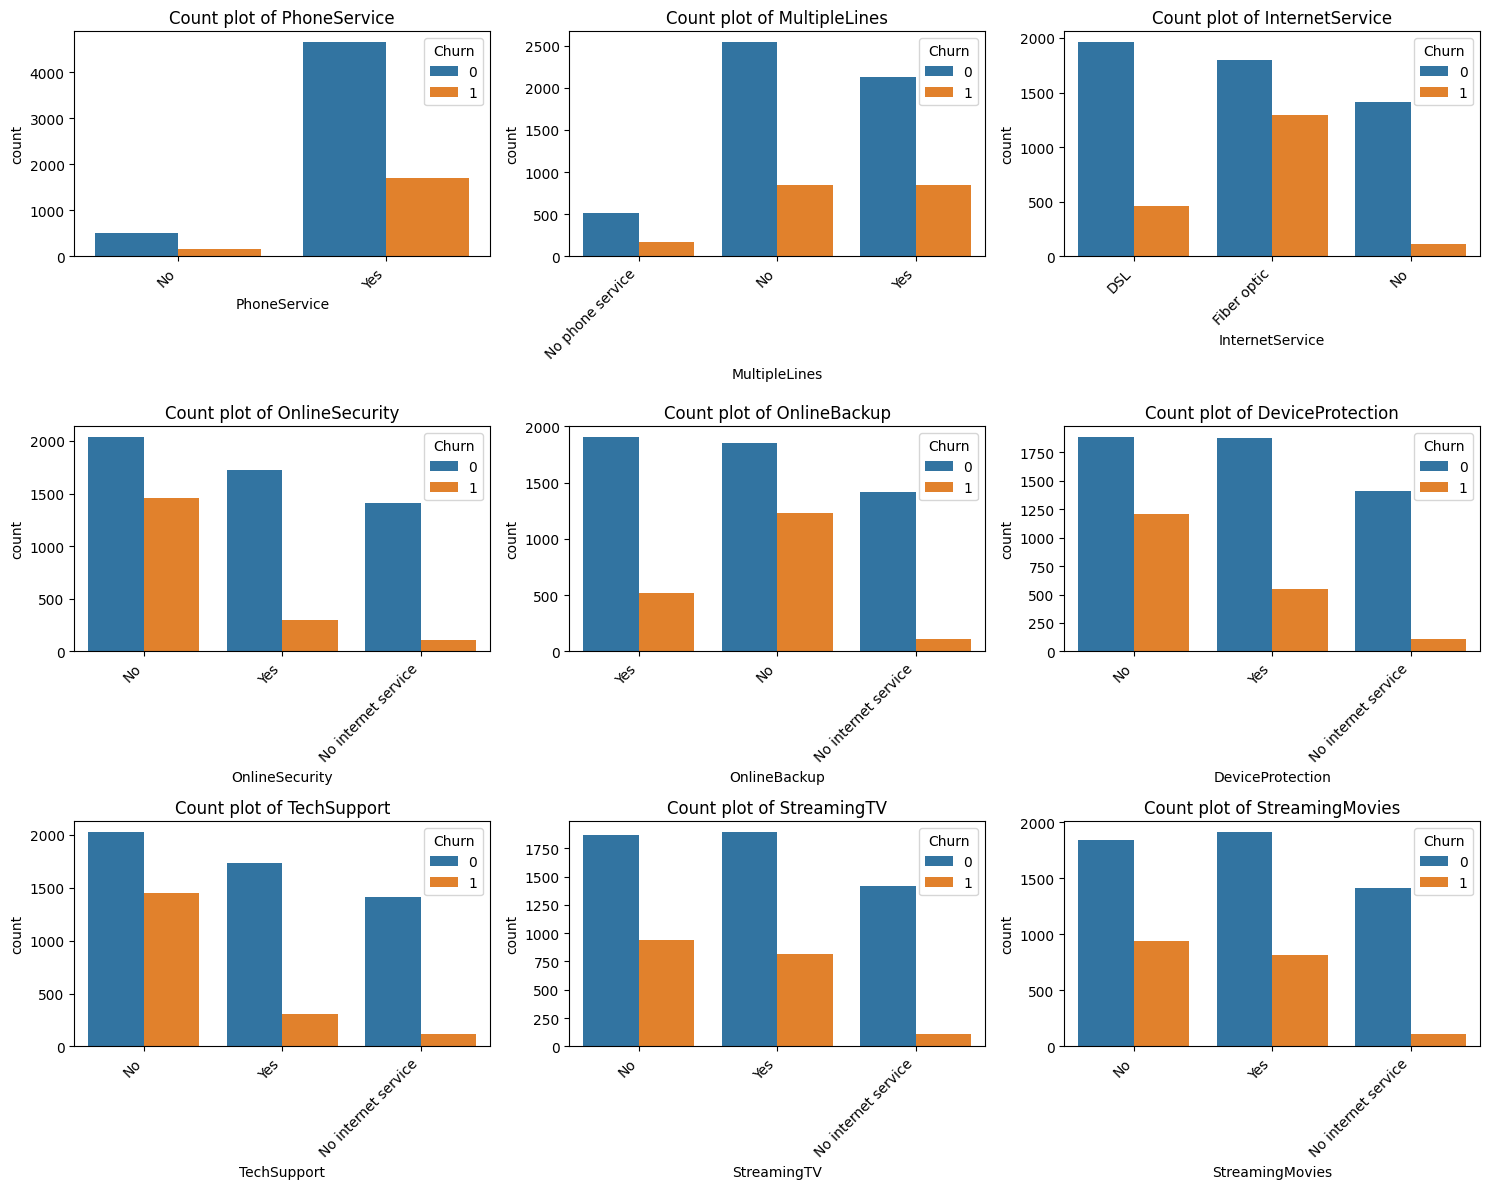

In [ ]:
# As per the above column values, from PhoneService till StreamingMovies are the services which are used by the customers.
# So here we can use subplot to generate multiple countplots.

# List of column names to create count plots for
columns = ['PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies']

# Set up the subplot grid (3 rows and 3 columns for 9 plots)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten axes array to iterate over easily
axes = axes.flatten()

# Generate the count plots for each column
for i, col in enumerate(columns):
    sns.countplot(x=col, data=df, ax=axes[i], hue='Churn')
    axes[i].set_title(f'Count plot of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

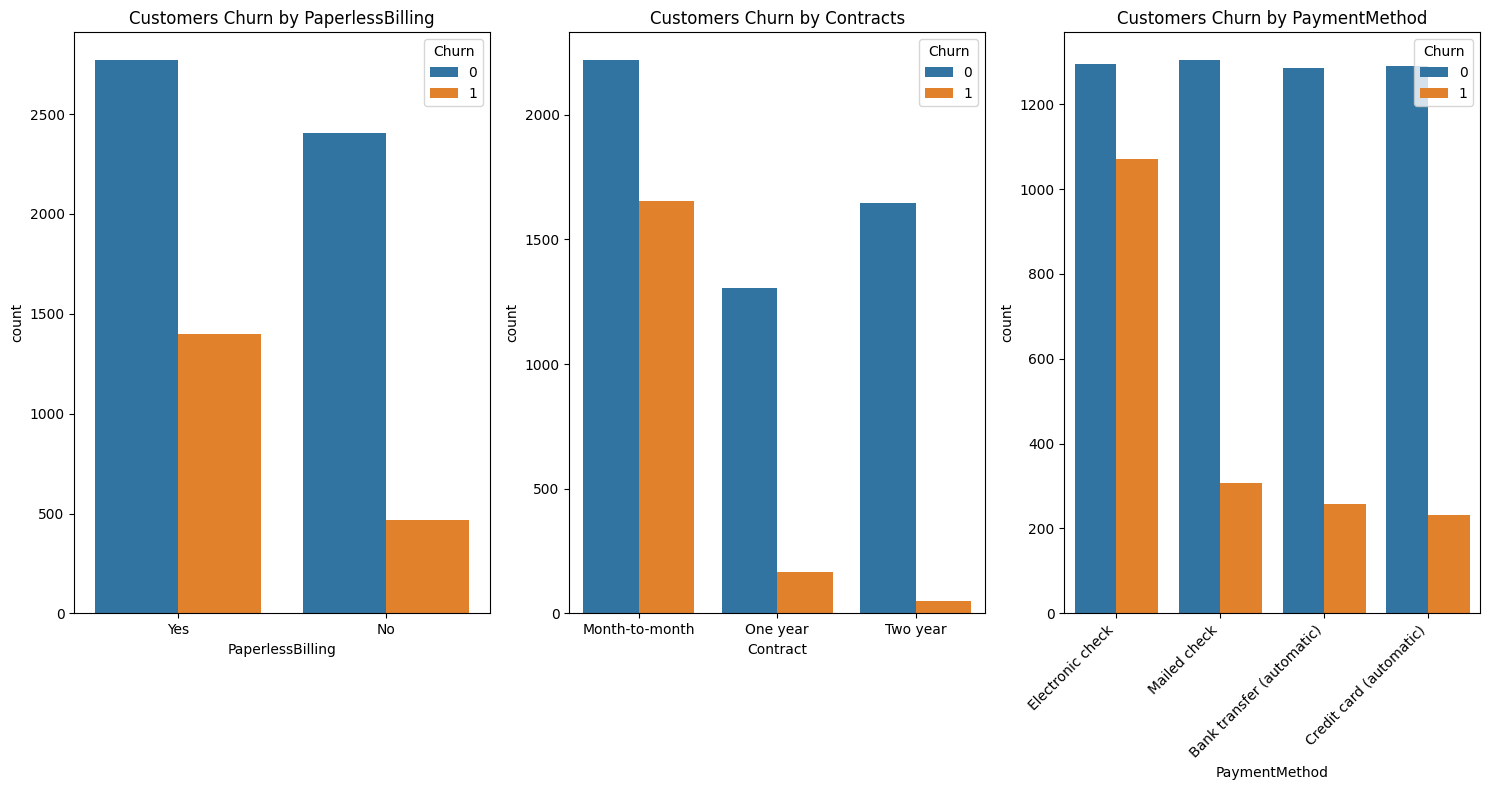

In [ ]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# First countplot for PaperlessBilling
ax = sns.countplot(x = "PaperlessBilling", data = df, hue='Churn', ax=axes[0])
axes[0].set_title("Customers Churn by PaperlessBilling")

# Second countplot for Contract
ax = sns.countplot(x = "Contract", data = df, hue='Churn', ax=axes[1])
axes[1].set_title("Customers Churn by Contracts")

# Third countplot for MonthlyCharges
ax = sns.countplot(x = "PaymentMethod", data = df, hue='Churn', ax=axes[2])
axes[2].set_title("Customers Churn by PaymentMethod")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

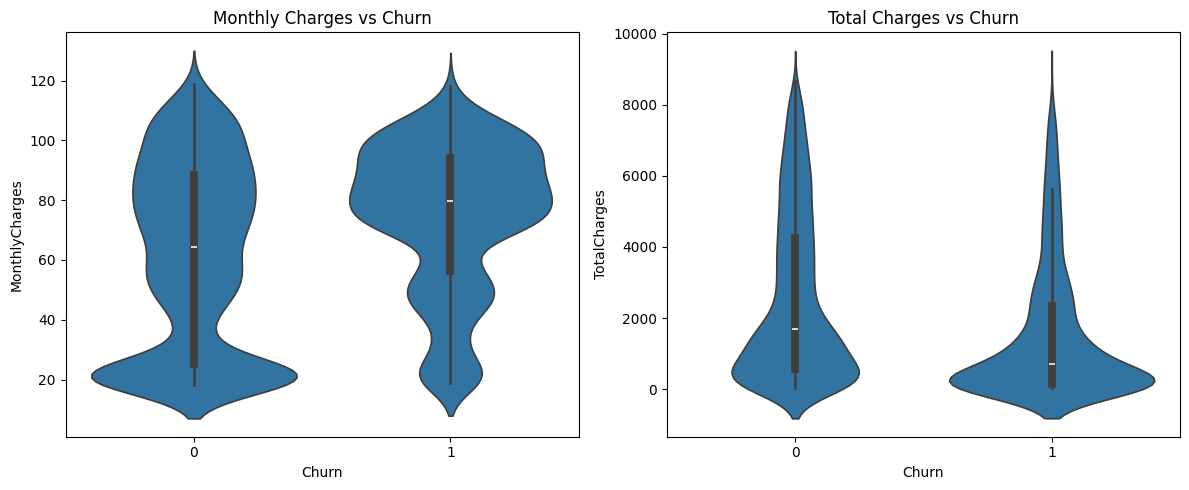

In [ ]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First violin plot for MonthlyCharges
sns.violinplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[0])
axes[0].set_title("Monthly Charges vs Churn")

# Second violin plot for TotalCharges
sns.violinplot(x='Churn', y='TotalCharges', data=df, ax=axes[1])
axes[1].set_title("Total Charges vs Churn")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

**c. Survival Analysis**

<Axes: xlabel='timeline'>

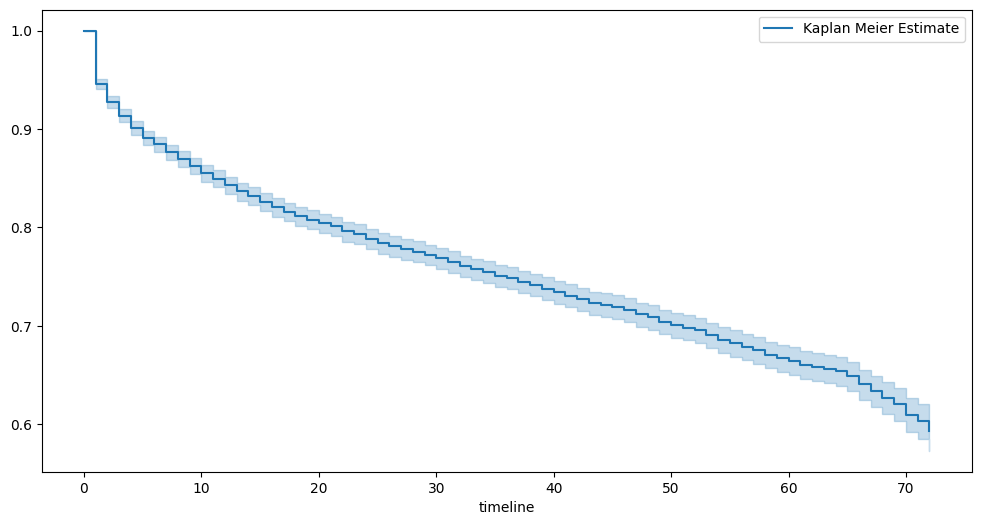

In [ ]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

## Import the library
from lifelines import KaplanMeierFitter


durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

Lets create Kaplan Meier Curves for Cohorts

<Axes: xlabel='timeline'>

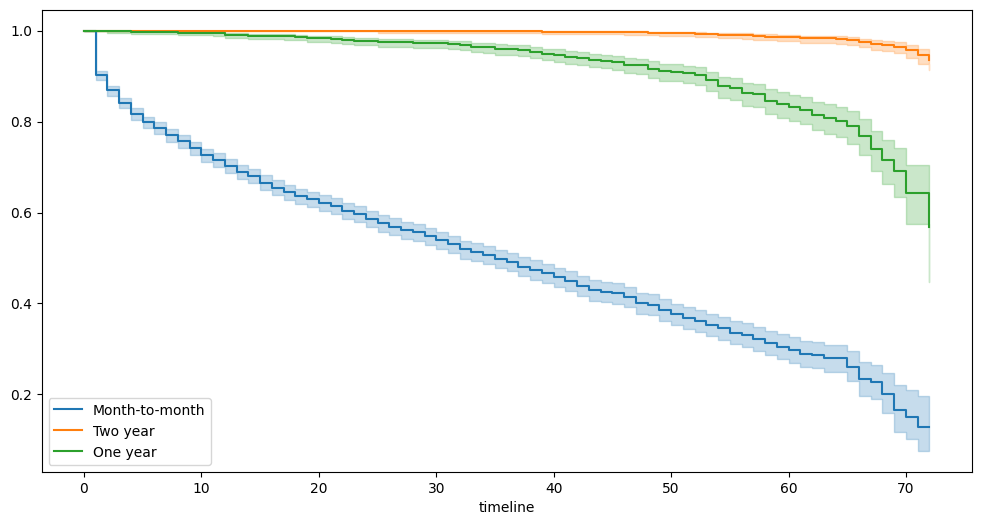

In [ ]:
kmf = KaplanMeierFitter()


T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored


groups = df['Contract']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'Month-to-month')   ## Cohort 1
ix2 = (groups == 'Two year')         ## Cohort 2
ix3 = (groups == 'One year')         ## Cohort 3


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the cohort 3 data
kmf.plot(ax=ax1)                                 ## Plot the KM curve for three cohort on same x and y axis

<Axes: xlabel='timeline'>

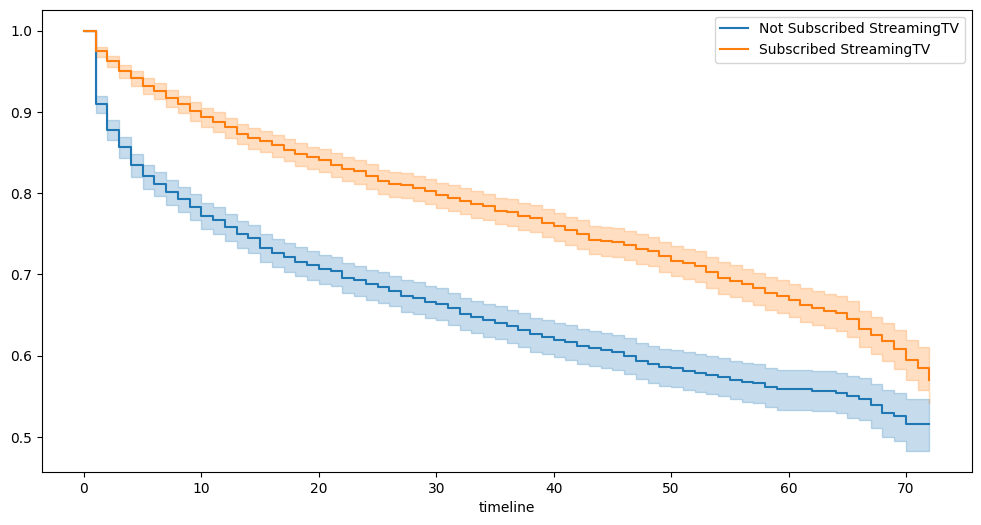

In [ ]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']
i1 = (groups == 'No')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)

Cox Proportional Hazard Model (Survival Regression)

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
## My objective here is to introduce you to the implementation of the model.Thus taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,No,No
1,34,0,Male,No,No,Yes,56.95,No,No
2,2,1,Male,No,No,Yes,53.85,No,No
3,45,0,Male,No,No,No,42.30,No,No
4,2,1,Female,No,No,Yes,70.70,No,No


In [ ]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,SeniorCitizen_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,False,True,False,False,False,False,False
1,34,0,56.95,True,False,False,True,False,False,False
2,2,1,53.85,True,False,False,True,False,False,False
3,45,0,42.30,True,False,False,False,False,False,False
4,2,1,70.70,False,False,False,True,False,False,False


In [ ]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2025-03-01 13:07:29 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
MonthlyCharges                  -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
gender_Male                     -0.01      0.99      0.05           -0.10            0.08                0.90                1.08
Partner_Yes                     -0.81      0.45      0.05           -0.92           -0.70                0.40                0.50
Dependents_Yes                  -0.36      0.70      0.07           -0.49           -0.22                0.61                0.80
PhoneService_Yes                 0.69      2.00      0.10            0.49            0.90                1.63                2.45
SeniorCitizen_Yes                0.40      1.49      0.06            0.29            0.50                1.33                1.66
StreamingTV_No internet service -2.10      0.12      0.13           -2.36           -1.84                0.09                0.16
StreamingTV_Yes                 -0.19      0.83      0.06           -0.31           -0.07                0.73                0.93

                                 cmp to      z      p  -log2(p)
covariate                                                      
MonthlyCharges                     0.00  -6.13 <0.005     30.06
gender_Male                        0.00  -0.23   0.82      0.29
Partner_Yes                        0.00 -14.93 <0.005    164.98
Dependents_Yes                     0.00  -5.21 <0.005     22.37
PhoneService_Yes                   0.00   6.65 <0.005     34.96
SeniorCitizen_Yes                  0.00   7.16 <0.005     40.15
StreamingTV_No internet service    0.00 -15.79 <0.005    184.09
StreamingTV_Yes                    0.00  -3.10 <0.005      9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

<Axes: xlabel='log(HR) (95% CI)'>

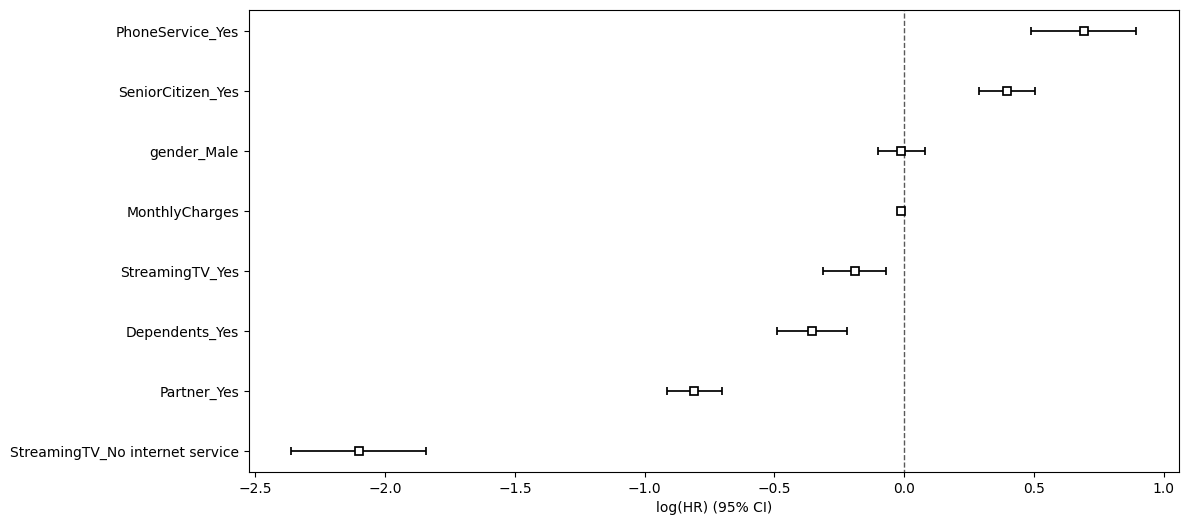

In [ ]:
cph.plot()

In [ ]:
## Check all the methods and attributes associated with the cph object.
dir(cph)

['AIC_',
 'AIC_partial_',
 '_ALLOWED_RESIDUALS',
 '_FAST_MEDIAN_PREDICT',
 '_KNOWN_MODEL',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_mode',
 '_censoring_type',
 '_central_values',
 '_check_values_post_fitting',
 '_check_values_pre_fitting',
 '_choose_gradient_calculator',
 '_class_name',
 '_clusters',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_central_values_of_raw_training_data',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_deviance',
 '_compute_martingale',
 '_compute_p_values',
 '_compute_sandwic

In [ ]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,SeniorCitizen_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,False,False,False,True,False,False,True
6,89.10,True,False,True,True,False,False,True
7,29.75,False,False,False,False,False,False,False
8,104.80,False,True,False,True,False,False,True
9,56.15,True,False,True,True,False,False,False


<Axes: >

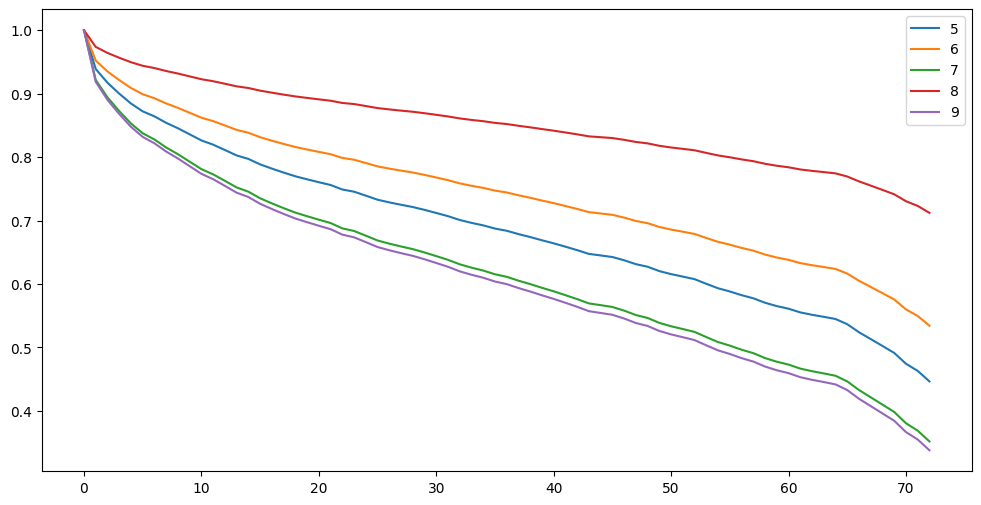

In [ ]:
## Lets predict the survival curve for the selected customers.
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()